# Predicting house prices with linear models

In this project, you will work with the Ames house data set which we already encountered in the lectures. Your task is to evaluate the following four linear models in terms of their performance when predicting house prices:

1. Linear regression
2. Ridge regression
3. Lasso
4. Elastic net

*General hints:*

1. Clearly label all graphs (axes, title, legend if required).
2. When asked to provide a specific answer (e.g., "Report the number of non-zero coefficients...") make sure the answer is clearly printed in the notebook.
3. Whenever a computation involves random number generation, initialise the seed to `123` to get reproducible results. Specifically, for `scikit-learn` functions this requires passing `random_state=123` where applicable.

## Data description

The data is stored in `data/ames_houses.csv` in the course [GitHub repository](https://github.com/richardfoltyn/MLFP-ECON5130) and can be downloaded using the link
[https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/data/ames_houses.csv](https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/data/ames_houses.csv).

To load the data, you need to specify the file path depending on your computing environment:

In [170]:
# Use this path if the CSV file is in the same directory as the Jupyter notebook
# file = 'ames_houses.csv'

# Use this path if you want to download the file directly from Github
file = 'https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130\
/main/exercises/ames_houses.csv'

You can load the CSV file as a `pandas` `DataFrame` as follows:

In [171]:
import pandas as pd

df = pd.read_csv(file, sep=',')

# Display columns in the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SalePrice         1460 non-null   float64
 1   LotArea           1460 non-null   float64
 2   Neighborhood      1460 non-null   object 
 3   BuildingType      1386 non-null   object 
 4   OverallQuality    1460 non-null   int64  
 5   OverallCondition  1460 non-null   int64  
 6   YearBuilt         1460 non-null   int64  
 7   CentralAir        1460 non-null   object 
 8   LivingArea        1460 non-null   float64
 9   Bathrooms         1460 non-null   int64  
 10  Bedrooms          1460 non-null   int64  
 11  Fireplaces        1460 non-null   int64  
 12  HasGarage         1460 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 148.4+ KB


The included variables are a simplified subset of the data available at [openml.org](https://www.openml.org/d/42165):

- `SalePrice`: House price in US dollars (float)
- `LotArea`: Size of the lot in m² (float)
- `Neighborhood`: Name of the neighborhood (string)
- `BuildingType`: Type of building (categorical stored as string)
- `OverallQuality`: Rates the overall condition of the house from (1) "very poor" to (10) "excellent" (integer)
- `OverallCondition`: Rates the overall material and finish of the house from (1) "very poor" to (10) "excellent" (integer)
- `YearBuilt`: Original construction date (integer)
- `CentralAir`: Central air conditioning: Yes/No (categorical string)
- `LivingArea`: Above-ground living area in m² (float)
- `Bathrooms`: Number of bathrooms (integer)
- `Bedrooms`: Number of bedrooms (integer)
- `Fireplaces`: Number of fireplaces (integer)
- `HasGarage`: Indicator whether house has a garage (integer)

# Data preprocessing

Apply the following steps to preprocess the data before estimation:

1. Drop all rows which contain any missing values (`NaN`)

    *Hint:* Use [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    to remove rows with missing observations.
    
2. Trim outliers:
    1. Compute the 1st and 99th percentiles of the variables 
        `SalePrice`, `LivingArea` and `LotArea`
    2. Drop all observations in which any of these variables is below its
        1st percentile or above its 99th percentile.

    *Hint:* Use [`quantile()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html)
    to compute the percentiles for the relevant variables. To convert percentiles to quantiles,
    you need to divide by 100.

3. Recode the string values in column `CentralAir` into numbers such that 
    `'N'` is mapped to 0 and `'Y'` is mapped to 1. Store this numerical variable
    using the column name `HasCentralAir`.
4. Recode the values in column `Fireplaces` and create the new variable `HasFireplace`
    so that `HasFireplace = 1` whenever at least one fireplace is present and 
    `HasFireplace = 0` otherwise.
5. Recode the string values in column `BuildingType` and create the new variable
    `IsSingleFamily` which takes on the value 1 whenever a house is a 
    single-family home and 0 otherwise.
6. Plot the kernel densities (or histograms) for the variables `SalePrice`, `LivingArea` and `LotArea`.
    You will notice that all three variables have a 
    [right-skewed](https://en.wikipedia.org/wiki/Skewness) distribution.
    
    *Hint:* You can plot kernel densities using 
    [`DataFrame.plot.kde()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.kde.html)
    and histograms with 
    [`DataFrame.plot.hist()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html)
7. Convert the variables `SalePrice`, `LivingArea` and `LotArea` to (natural) logs and re-create
    the kernel density or histogram plots for the logged variables.
    Name the transformed columns `logSalePrice`, `logLivingArea` and `logLotArea`.

In [172]:
# Drop nan rows and trim outliers
import numpy as np

features_to_recode = ['SalePrice', 'LivingArea', 'LotArea']
log_features = ['logSalePrice', 'logLivingArea', 'logLotArea']
df.dropna(inplace=True)
for feature in features_to_recode:
   df.loc[(df[feature] <= df[feature].quantile(0.01)) |\
      (df[feature] >= df[feature].quantile(0.99)), feature] = np.nan
df.dropna(inplace=True)
df.shape

(1317, 13)

,SalePrice,LotArea,OverallQuality,OverallCondition,YearBuilt,LivingArea,Bathrooms,Bedrooms,Fireplaces,HasGarage,HasCentralAir,HasFireplace,IsSingleFamily,logSalePrice,logLivingArea,logLotArea
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.0,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000
mean,180516.920273,931.324999,6.125285,5.586181,1972.281701,139.842531,1.561124,2.885345,0.615793,1.0,0.949886,0.538345,0.883827,12.039553,4.894052,6.768351
std,67712.511554,359.321805,1.306498,1.083683,29.558716,42.963756,0.534757,0.776599,0.630766,0.0,0.218263,0.498717,0.320554,0.354147,0.306064,0.374276
min,62383.000000,247.562439,3.000000,2.000000,1872.000000,65.768933,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,11.041048,4.186148,5.511663
25%,133000.000000,730.332418,5.000000,5.000000,1954.000000,106.084918,1.000000,2.000000,0.000000,1.0,1.000000,0.000000,1.000000,11.798104,4.664240,6.593500
50%,165500.000000,889.088219,6.000000,5.000000,1975.000000,136.739929,2.000000,3.000000,1.000000,1.0,1.000000,1.000000,1.000000,12.016726,4.918081,6.790196
75%,214500.000000,1076.083787,7.000000,6.000000,2001.000000,164.793909,2.000000,3.000000,1.000000,1.0,1.000000,1.000000,1.000000,12.276065,5.104696,6.981084
max,446261.000000,3390.630026,10.000000,9.000000,2010.000000,289.086045,3.000000,6.000000,3.000000,1.0,1.000000,1.000000,1.000000,13.008659,5.666724,8.128771


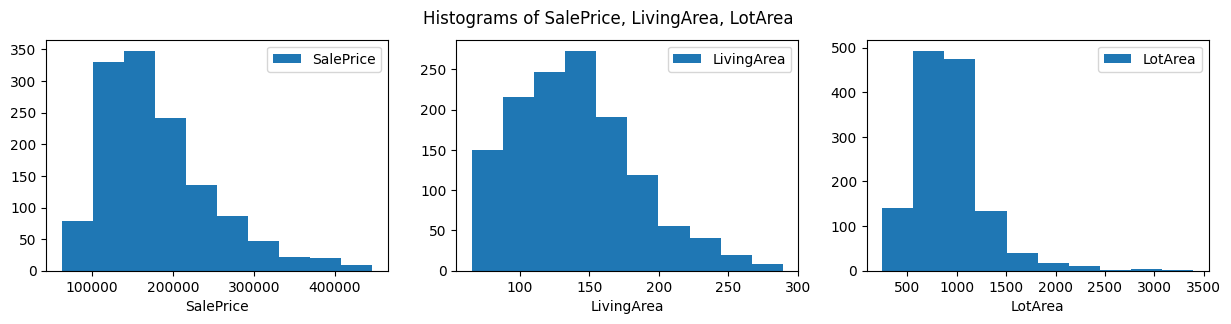

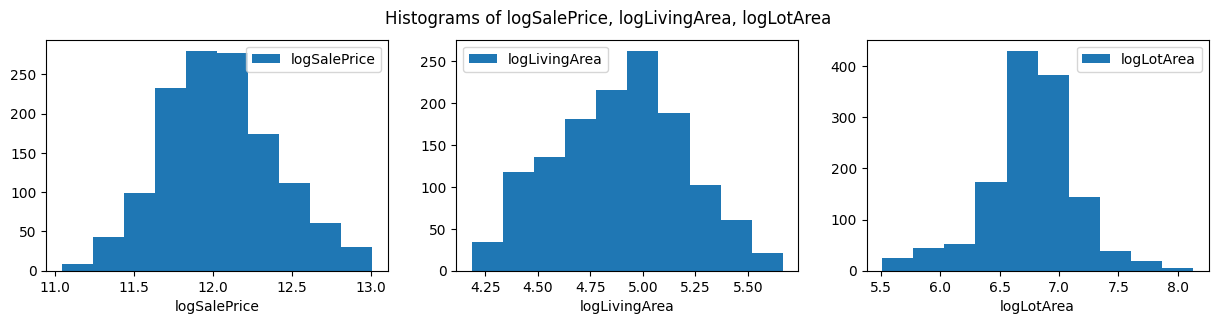

In [173]:
# Recode CentralAir, Fireplaces, BuildingType

import matplotlib.pyplot as plt

df['HasCentralAir'] = df.\
    apply(lambda row: 1 if row.CentralAir == 'Y' else 0, axis=1)
df['HasFireplace'] = df.\
    apply(lambda row: 1 if row.Fireplaces >= 1 else 0, axis=1)
df['IsSingleFamily'] = df.\
    apply(lambda row: 1 if row.BuildingType == 'Single-family'\
        else 0, axis=1)

# Plot Histograms of SalePrice, LivingArea, LotArea
fig, axis = plt.subplots(1,3,figsize=(15,3))
fig.suptitle('Histograms of SalePrice, LivingArea, LotArea')
for idx, col in enumerate(features_to_recode):
    axis[idx].hist(df[col], label=col)
    axis[idx].set_xlabel(col)
    axis[idx].legend()

# Find logSalePrice, logLivingArea, logLotArea
df['logSalePrice'] = np.log(df['SalePrice'])
df['logLivingArea'] = np.log(df['LivingArea'])
df['logLotArea'] = np.log(df['LotArea'])

# Plot Histograms of logSalePrice, logLivingArea, logLotArea
fig, axis = plt.subplots(1,3,figsize=(15,3))
fig.suptitle('Histograms of logSalePrice, logLivingArea, logLotArea')
for idx, col in enumerate(log_features):
    axis[idx].hist(df[col], label=col)
    axis[idx].set_xlabel(col)
    axis[idx].legend()
df.describe()

# Estimation

## Model specification

You are now asked to estimate the following model of house prices
as a function of house characteristics:
$$
\begin{aligned}
\log(SalePrice_i) 
    &= \alpha + f\Bigl(\log(LivingArea_i), ~
        \log(LotArea_i), ~OverallCondition_i, \\
    & \qquad \qquad \qquad  OverallQuality_i,~ 
    Bathrooms_i,~ Bedrooms_i\Bigr) \\
    &+ \gamma_0 YearBuilt_i + 
    \gamma_1 HasCentralAir_i + 
    \gamma_2 HasFireplace_i + 
    \gamma_3 IsSingleFamily_i + 
    \epsilon_i
\end{aligned}
$$
where $i$ indexes observations and $\epsilon$ is an additive error term.
The function $f(\bullet)$ is a *polynomial of degree 3* in its
arguments, i.e., it includes all terms and interactions of the given variables
where the exponents sum to 3 or less:
$$
\begin{aligned}
f(\log(LivingArea_i), \log(LotArea_i), \dots)
    &= \beta_0 \log(LivingArea_i) 
    + \beta_1 \log(LivingArea_i)^2 \\
    &+ \beta_2 \log(LivingArea_i)^3 
    + \beta_3 \log(LotArea_i) \\
    &+ \beta_4 \log(LotArea_i)^2
    + \beta_5 \log(LotArea_i)^3 \\
    &+ \beta_6 \log(LivingArea_i)\log(LotArea_i) \\
    &+ \beta_7 \log(LivingArea_i)^2 \log(LotArea_i) \\
    &+ \beta_8 \log(LivingArea_i) \log(LotArea_i)^2 \\
    &+ \cdots 
\end{aligned}
$$

Create a feature matrix `X` which contains all polynomial interactions as well as the remaining non-interacted variables.

*Hints:* 

- Use the 
[`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
transformation to create the polynomial terms and interactions from the columns
    `logLivingArea`, `logLotArea`, 
    `OverallCondition`, `OverallQuality`, 
    `Bathrooms` and  `Bedrooms`.
- Make sure that the generated polynomial does *not* contain a 
constant ("bias"). You should include the intercept when estimating a model instead.
- You can use [`np.hstack()`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) to concatenate two matrices (the polynomials and the remaining covariates) along the column dimension.
- The complete feature matrix `X` should contain a total of 87 columns.

In [174]:
from sklearn.preprocessing import PolynomialFeatures

f_features = ['logLivingArea', 'logLotArea', 'OverallCondition',\
    'OverallQuality', 'Bathrooms', 'Bedrooms']
o_features = ['YearBuilt', 'HasCentralAir', 'HasFireplace',\
    'IsSingleFamily']
poly_features = PolynomialFeatures(3, include_bias=False)
X = poly_features.fit_transform(df[f_features])
X = np.hstack((X, df[o_features]))
X.shape

(1317, 87)

## Train-test sample split

Split the data into a training and a test subset such that the training
sample contains 70% of observations.

*Hint:* 

- Use the function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the sample.
    Pass the argument `random_state=123` to get reproducible results.
- Make sure to define the training and test samples only *once* so that they are identical for all estimators used below. 

In [175]:
from sklearn.model_selection import train_test_split

random_state = 123
test_size = 0.3
Y = df['logSalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=test_size,
    random_state=random_state
)

## Linear regression

Perform the following tasks:

1. Comment on whether you need to standardise features before estimating a linear regression model. Does the linear regression model have any hyperparameters?
2. Estimate the above model specification using a linear regression model on the training sub-set. 
3. Compute and report the mean squared error (MSE) on the test sample.
4. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:*

- Use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class to estimate the model.
- The mean squared error can be computed with [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

Linear regression does not have any hyper parameters
No, we don't need to standardis features. Standarising features is not going to be beneficial for us in linear regression since there is no hyper parameters.
Mean squared error(Linear Regression) is 0.024052


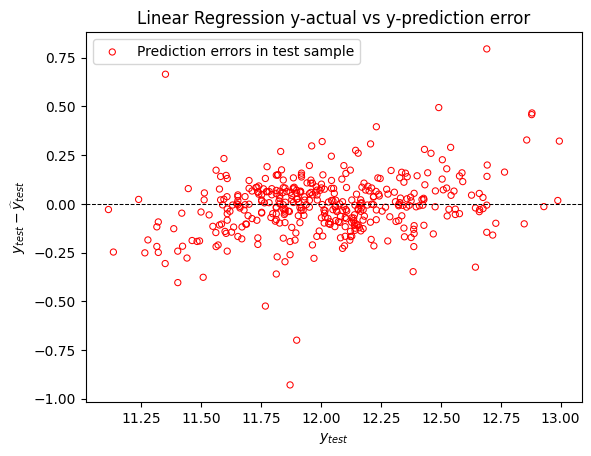

In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

print("Linear regression does not have any hyper parameters")
print("No, we don't need to standardis features. Standarising features \
is not going to be beneficial for us in linear regression since \
there is no hyper parameters.")
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, Y_train)
Y_test_hat = lr.predict(X_test)

errors = Y_test - Y_test_hat
error_linear = mean_squared_error(Y_test, Y_test_hat)
print(f'Mean squared error(Linear Regression) is {error_linear:.6f}')

plt.scatter(Y_test, errors, s=20, lw=0.75, 
    color='none', edgecolor='red', 
    label='Prediction errors in test sample'
)
plt.title('Linear Regression y-actual vs y-prediction error')
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.legend()
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$y_{test} - \widehat{y}_{test}$');

## Ridge regression

Perform the following tasks:

1. Does Ridge regression require feature standardisation? If so, don't forget to apply it before fitting the model.
2. Use [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
    to determine the best regularisation strength $\alpha$ on the training sub-sample.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.
3. Plot the MSE (averaged over folds on the training sub-sample) against the regularisation strength $\alpha$ on the $x$-axis (use a log scale for the $x$-axis).
4. Compute and report the MSE on the test sample.
5. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:* 

- Determine a suitable range for the grid of candidate $\alpha$ and space them uniformly in logs. 
- Recall that the (negative!) best MSE is stored in the attribute `best_score_` after cross-validation is complete.

In [177]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

print('Ridger regreesion requires featuer standardisation')
print('Standardization will confine the range between zero and one, \
distribution with mean 0 and standard deviation 1.')
print('Since the regularisation parameter (alpha) depends on the sum \
of squares of all the coefficients, every variable will have a different \
contribution to the penalising metric. Hence, we need to \
standardize our features.')
X_train_ridge = scaler.fit_transform(X_train) # Should we use X_train or X?(For all standardisation regressions)
alphas = np.logspace(start=np.log10(1.0e-6), stop=np.log10(100), num=500)
rcv = RidgeCV(alphas=alphas, store_cv_values=True)
rcv.fit(X_train_ridge, Y_train)
alpha_best = rcv.alpha_
MSE_best = - rcv.best_score_

print(f'Best alpha: {alpha_best:.6f} (MSE: {MSE_best:.6f})')

Ridger regreesion requires featuer standardisation
Standardization will confine the range between zero and one, distribution with mean 0 and standard deviation 1.
Since the regularisation parameter (alpha) depends on the sum of squares of all the coefficients, every variable will have a different contribution to the penalising metric. Hence, we need to standardize our features.
Best alpha: 7.830465 (MSE: 0.016810)


(921, 500)


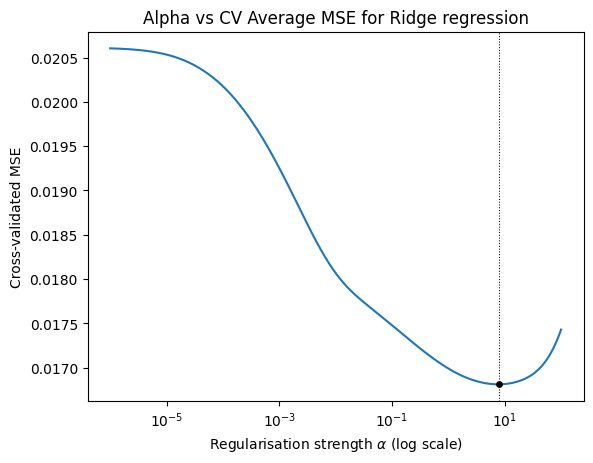

In [178]:
# Compute average MSE for each alpha value across all folds
mse_mean = np.mean(rcv.cv_values_, axis=0)
print(rcv.cv_values_.shape)
# Index of MSE-minimising alpha
imin = np.argmin(mse_mean)

# Plot MSE against alphas, highlight minimum MSE
plt.title('Alpha vs CV Average MSE for Ridge regression')
plt.plot(alphas, mse_mean)
plt.xlabel(r'Regularisation strength $\alpha$ (log scale)')
plt.ylabel('Cross-validated MSE')
plt.scatter(alphas[imin], mse_mean[imin], s=15, c='black', zorder=100)
plt.axvline(alphas[imin], ls=':', lw=0.75, c='black')
plt.xscale('log')

Mean squared error(Ridge Regression) is 0.017752


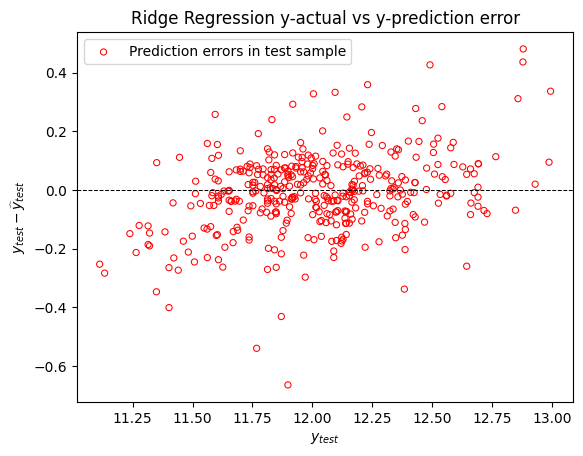

In [179]:
from sklearn.pipeline import make_pipeline

ridge = Ridge(alpha=alpha_best, fit_intercept=True)
pipe_ridge = make_pipeline(StandardScaler(), ridge)
pipe_ridge.fit(X_train, Y_train)
Y_test_hat = pipe_ridge.predict(X_test)

errors = Y_test - Y_test_hat
error_ridge = mean_squared_error(Y_test, Y_test_hat)

print(f'Mean squared error(Ridge Regression) is {error_ridge:.6f}')

plt.scatter(Y_test, errors, s=20, lw=0.75, 
    color='none', edgecolor='red', 
    label='Prediction errors in test sample'
)
plt.title('Ridge Regression y-actual vs y-prediction error')
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.legend()
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$y_{test} - \widehat{y}_{test}$');

## Lasso

Perform the following tasks:

1. Does Lasso require feature standardisation? If so, don't forget to apply it before fitting the model.
2. Use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
    to determine the best regularisation strength $\alpha$ on the training sub-sample
    using cross-validation with 5 folds.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.
3. Plot the MSE (averaged over folds on the training sub-sample) against the regularisation strength $\alpha$ on the $x$-axis (use a log scale for the $x$-axis).
4. Compute and report the MSE on the test sample for the model using the optimal $\alpha$.
5. Report the number of non-zero coefficients for the model using the optimal $\alpha$.
6. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:* 

- Getting Lasso to converge may require some experimentation. The following settings should help: increase the max. number of iterations to `max_iter=100000` and use `selection='random'`. Set `random_state=123` to get reproducible results:

    ```python
    LassoCV(..., max_iter=100000, selection='random', random_state=123)
    ```

- After cross-validation is complete, the MSE for each value of $\alpha$ and each fold are stored in the attribute `mse_path_` which is an array with shape `(N_ALPHA, N_FOLDS)`.

In [180]:
from sklearn.linear_model import Lasso, LassoCV

X_train_lasso = scaler.fit_transform(X_train)
print('Lasso regreesion requires featuer standardisation')
print('Standardization will confine the range between zero and one, \
distribution with mean 0 and standard deviation 1.')
print('Lasso regression puts constraints on the size of the coefficients \
associated to each variable. However, this value will depend on the \
magnitude of each variable. It is therefore necessary to standardize \
the variables.')
lcv = LassoCV(eps=1.0e-4, n_alphas=200, max_iter=100000, 
              selection='random', random_state=random_state, cv=5)
lcv.fit(X_train_lasso, Y_train)
# Recover best alpha that minimizes MSE
alpha_best = lcv.alpha_

# MSE for each alpha, averaged over folds
mse_mean = np.mean(lcv.mse_path_, axis=1)
# Index of min. MSE
imin = np.argmin(mse_mean)

mse_best = mse_mean[imin]

print(f'Best alpha: {alpha_best:.6f} (MSE: {mse_best:.6f})')

Lasso regreesion requires featuer standardisation
Standardization will confine the range between zero and one, distribution with mean 0 and standard deviation 1.
Lasso regression puts constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. It is therefore necessary to standardize the variables.
Best alpha: 0.000638 (MSE: 0.017050)


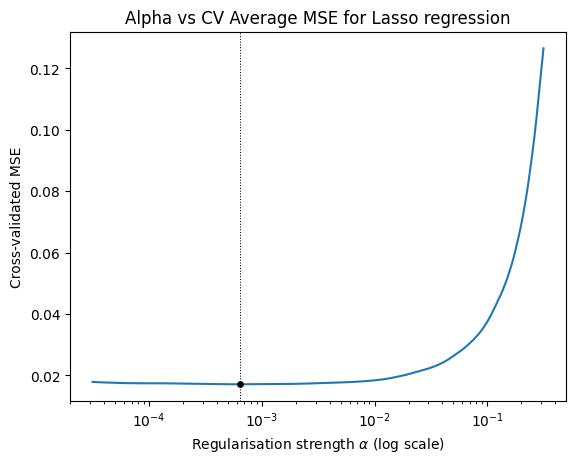

In [181]:
# Recover grid of alphas used for CV
alphas = lcv.alphas_

# Plot MSE against alphas, highlight minimum MSE
plt.title('Alpha vs CV Average MSE for Lasso regression')
plt.plot(alphas, mse_mean)
plt.xlabel(r'Regularisation strength $\alpha$ (log scale)')
plt.ylabel('Cross-validated MSE')
plt.scatter(alphas[imin], mse_mean[imin], s=15, c='black', zorder=100)
plt.axvline(alphas[imin], ls=':', lw=0.75, c='black')
plt.xscale('log')

Mean squared error(Lasso Regression) is 0.017666
Non Zero Coefficients(Lasso Regression): 19


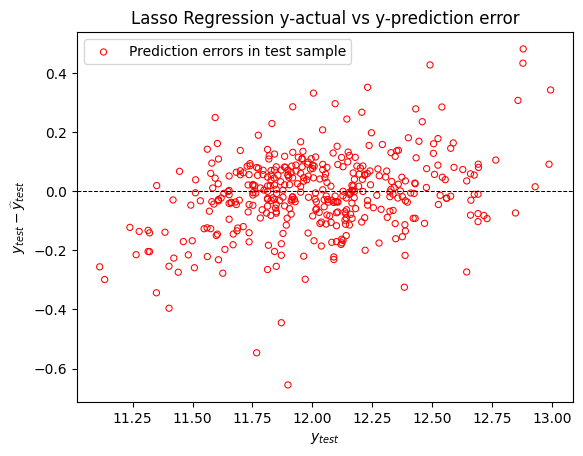

In [182]:
lasso = Lasso(alpha=alpha_best, fit_intercept=True, max_iter=100000, 
              selection='random', random_state=random_state)
pipe_lasso = make_pipeline(StandardScaler(), lasso)
pipe_lasso.fit(X_train, Y_train)
Y_test_hat = pipe_lasso.predict(X_test)

errors = Y_test - Y_test_hat
error_lasso = mean_squared_error(Y_test, Y_test_hat)
print(f'Mean squared error(Lasso Regression) is {error_lasso:.6f}')
print(f'Non Zero Coefficients(Lasso Regression): \
{np.count_nonzero(lasso.coef_)}')

plt.title('Lasso Regression y-actual vs y-prediction error')
plt.scatter(Y_test, errors, s=20, lw=0.75, 
    color='none', edgecolor='red', 
    label='Prediction errors in test sample'
)
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.legend()
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$y_{test} - \widehat{y}_{test}$');

## Elastic net

The elastic net is a linear model that applies both L1 and L2 regularisation, i.e., it's a generalisation of Ridge regression and Lasso. Its loss function is given by
$$
L(\mu, \mathbf{\beta}) = \frac{1}{2N}
    \underbrace{\sum_{i=1}^N \Bigl(
    y_i - \mu - \mathbf{x}_i'\mathbf{\beta}\Bigr)^2}_{\text{Sum of squared errors}}
    + 
    \underbrace{\alpha \rho \sum_{k=1}^K |\beta_k|}_{\text{L1 penalty}}    
    + 
    \underbrace{\alpha (1-\rho) \sum_{k=1}^K\beta_k^2}_{\text{L2 penalty}}
$$
The additional parameter $\rho$ is called the L1 ratio and determines the relative weight of the L1 vs L2 penalty terms (see also the `scikit-learn` 
[user guide](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)).
Compared to Ridge regression and Lasso, this model therefore includes two hyperparameters, $\alpha$ and $\rho$, both of which should be determined using cross-validation.
It is easy to see that for the corner case of $\rho = 1$, the elastic net corresponds to the Lasso, while for $\rho = 0$ is corresponds to Ridge regression.

Perform the following tasks:

1. Does the elastic net require feature standardisation?
2. Use [`ElasticNetCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
    to determine the best regularisation strength $\alpha$ and L1 ratio $\rho$ on the training sub-sample
    using cross-validation with 5 folds.
    You can use the MSE metric (the default) to find the optimal hyperparameter values.
    Report the optimal $\alpha$ and $\rho$ and the corresponding MSE.
3. Compute and report the MSE on the test sample for the model with optimal hyperparameters.
4. Report the number of non-zero coefficients for the model with optimal hyperparameters.
5. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:* 

- Getting elastic net to converge may require some experimentation. The following settings should help: increase the max. number of iterations to `max_iter=100000` and use `selection='random'`. Set `random_state=123` to get reproducible results. 

    ```python
    ElasticNetCV(..., max_iter=100000, selection='random', random_state=123)
    ```

- The grid for $\alpha$ is determined in the same way as for `LassoCV`. For $\rho$, use the argument `l1_ratio` to pass a grid of candidate L1 rations given by `[0.1, 0.5, 0.7, 0.9, 0.95, 0.99]`:

    ```python
    ElasticNetCV(..., l1_ratios=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99], ...)
    ```

- Use [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to estimate the elastic net once you identified the optimal hyperparameters.
    Make sure to pass the same values for `max_iter`, `selection` and `random_state` as you did earlier.

In [183]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

print('ElasticNet regreesion requires featuer standardisation')
print('Standardization will confine the range between zero and one, \
distribution with mean 0 and standard deviation 1.')
print('Determining the coefficients of penalty for lasso and ridge \
regression requires features to be scaled. ')
X_train_elastic = scaler.fit_transform(X_train)
ecv = ElasticNetCV(eps=1.0e-4, n_alphas= 200, 
                   l1_ratio=[0.1,0.5,0.7,0.95,0.99], 
                   max_iter=100000, selection='random', 
                   random_state=random_state, cv=5)
ecv.fit(X_train_elastic, Y_train)
# Recover best alpha that minimizes MSE
alpha_best = ecv.alpha_
l1_best = ecv.l1_ratio_

# MSE for each alpha, averaged over folds
mse_mean = np.mean(ecv.mse_path_, axis=2)
# Index of min. MSE
imin = np.argmin(mse_mean)

mse_best = mse_mean.flatten()[imin]

print(f'Best L1: {l1_best:.6f} Best alpha: {alpha_best:.6f} \
(MSE: {mse_best:.6f})')

ElasticNet regreesion requires featuer standardisation
Standardization will confine the range between zero and one, distribution with mean 0 and standard deviation 1.
Determining the coefficients of penalty for lasso and ridge regression requires features to be scaled. 
Best L1: 0.700000 Best alpha: 0.000911 (MSE: 0.017044)


Mean squared error(ElasticNet Regression) is 0.017656
Non Zero Coefficients(ElasticNet Regression): 22


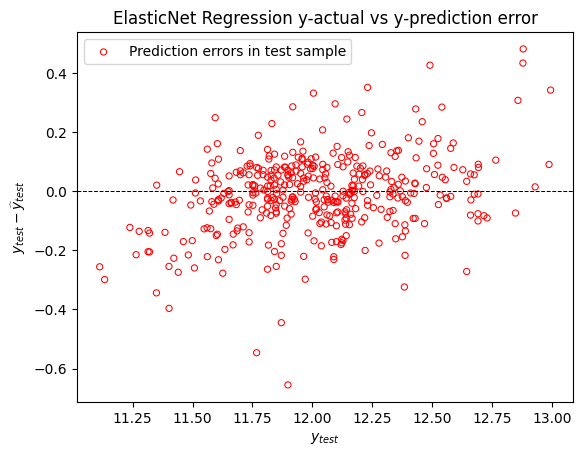

In [184]:
elasticnet = ElasticNet(alpha=alpha_best, l1_ratio=l1_best, 
                        fit_intercept=True, max_iter=100000, 
                        random_state=random_state, selection='random')
pipe_elasticnet = make_pipeline(StandardScaler(), elasticnet)
pipe_elasticnet.fit(X_train, Y_train)
Y_test_hat = pipe_elasticnet.predict(X_test)

# Compute prediction errors
errors = Y_test - Y_test_hat
error_en = mean_squared_error(Y_test, Y_test_hat)
print(f'Mean squared error(ElasticNet Regression) is {error_en:.6f}')
print(f'Non Zero Coefficients(ElasticNet Regression): \
{np.count_nonzero(elasticnet.coef_)}')

plt.title('ElasticNet Regression y-actual vs y-prediction error')
plt.scatter(Y_test, errors, s=20, lw=0.75, 
    color='none', edgecolor='red', 
    label='Prediction errors in test sample'
)
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.legend()
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$y_{test} - \widehat{y}_{test}$');

## Compare estimation results

Create a table which contains the MSE computed on the test sample for all four models (using their optimal hyperparameters). Which model yields the lowest MSE? Comment on why you think this is the case.

In [185]:
errors = [error_linear, error_ridge, error_lasso,error_en]
label = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']
print('ElasticNet model yields the lowest MSE, the reason is elastic net \
uses both lasso and ridger standardisation. So it eliminates features \
and reduce overfitting like Lasso and reduces coefficient of features \
like ridge which results in better prediction compared to the other models.')
pd.DataFrame({'Regression Type': label, 'MSE Errors': errors})

ElasticNet model yields the lowest MSE, the reason is elastic net uses both lasso and ridger standardisation. So it eliminates features and reduce overfitting like Lasso and reduces coefficient of features like ridge which results in better prediction compared to the other models.


,Regression Type,MSE Errors
0,Linear,0.024052
1,Ridge,0.017752
2,Lasso,0.017666
3,ElasticNet,0.017656
